# A coupled rainfall-runoff model in Landlab

This tutorial demonstrates a very simple synthetic rainfall-runoff model in Landlab, using the `SpatialPrecipitationDistribution` and `OverlandFlow` components. This assumes no infiltration, but it could be added by modifying the `rainfall__flux` field appropriately.

First, import the modules we'll need.

In [1]:
%matplotlib notebook
import os
import numpy as np
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
import matplotlib.pyplot as plt

Set up a grid and load some arbitrary existing catchment elevation data. A functional version of this might use a real gauged catchment for comparison to reality.

<IPython.core.display.Javascript object>


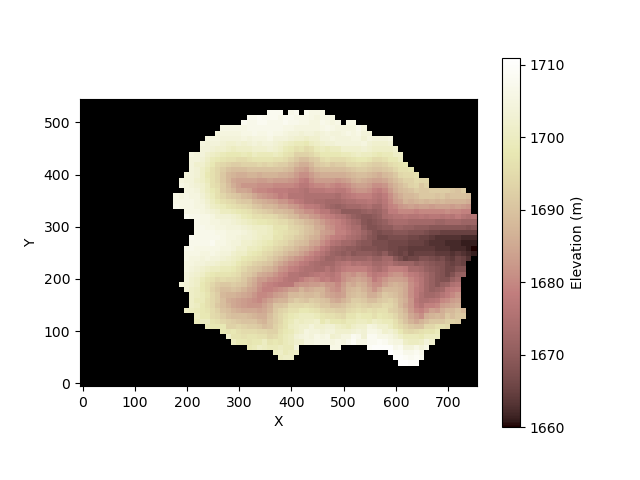

C:\Users\gjg882\Anaconda3\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
C:\Users\gjg882\Anaconda3\lib\site-packages\landlab\plot\imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


In [2]:
# here we use an arbitrary, very small, "real" catchment
fname = 'hugo_site.asc'
mg, z = read_esri_ascii(fname, name='topographic__elevation')
mg.status_at_node[mg.nodes_at_right_edge] = mg.BC_NODE_IS_FIXED_VALUE
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED

plt.figure()
imshow_grid_at_node(mg, z, colorbar_label='Elevation (m)')
plt.show()

Build a mocked-up rainfall distribution using the `SpatialPrecipitationDistribution` component.

It would be trivial to replace this with an imported real rainfall field - and we save and reload the pattern to highlight how this might work.

<IPython.core.display.Javascript object>


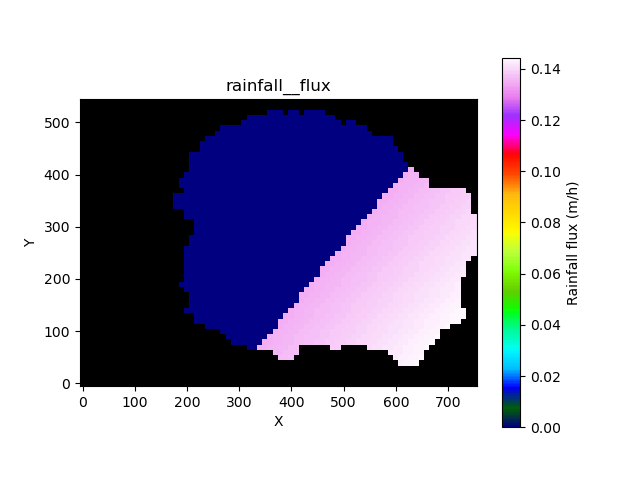

C:\Users\gjg882\Anaconda3\lib\site-packages\landlab\plot\imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_ncar"))
  cmap.set_bad(color=color_for_closed)


In [3]:
rain = SpatialPrecipitationDistribution(mg)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every time

# get the storm simulator to provide a storm
# There's only one storm generated here in the time series, so easy enough to do.
# first, check the directory we need for saving exists, and make it if not:
if not os.path.exists('./rainfall'):
    os.makedirs('./rainfall')
for (storm_t, interstorm_t) in rain.yield_storms(style='monsoonal'):  # storm lengths in hrs
    mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    mg.at_node['rainfall__flux'] *= 10.  # to make the storm heavier and more interesting!
    plt.figure()
    # plot up this storm
    imshow_grid_at_node(
        mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (m/h)'
    )
    plt.show()
    write_esri_ascii('./rainfall/rainfall.asc', mg, 'rainfall__flux', clobber=True)

Now, load the rainfall files and set up the model, telling the flood router to accept the rainfalls in the file(s) as inputs. 

In the first instance, this is set up as an instantaneous storm, with all the water dropped over the catchment in one go. Below, we modify this assumption to allow time distributed rainfall.

<IPython.core.display.Javascript object>


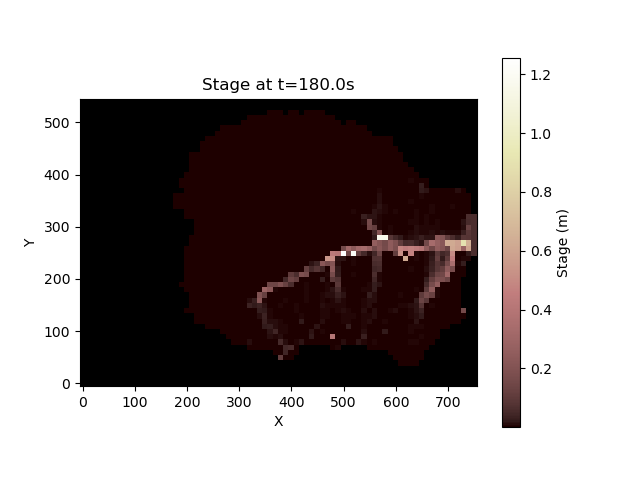

<IPython.core.display.Javascript object>


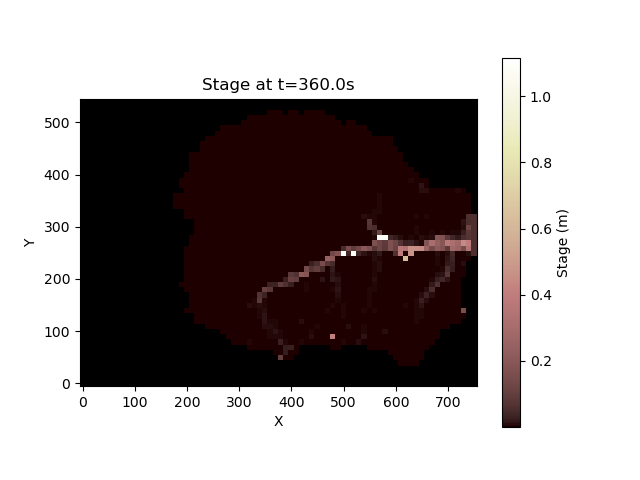

<IPython.core.display.Javascript object>


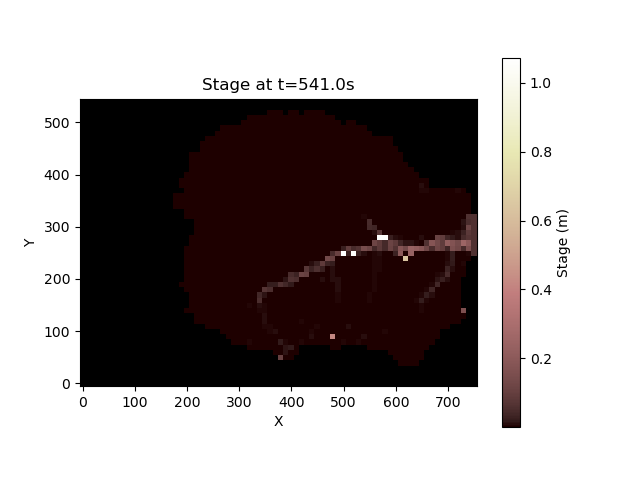

<IPython.core.display.Javascript object>


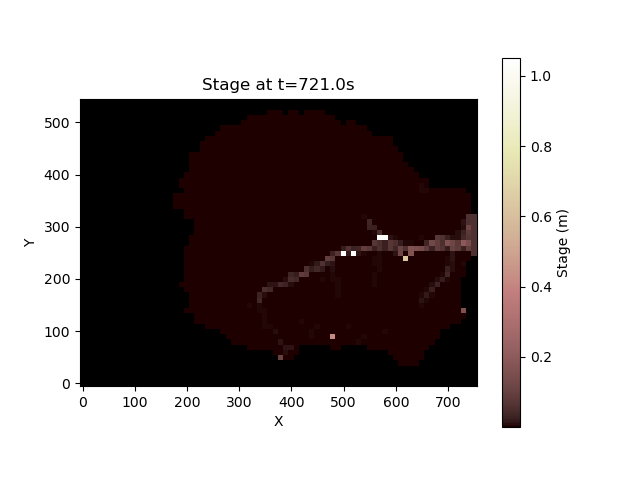

<IPython.core.display.Javascript object>


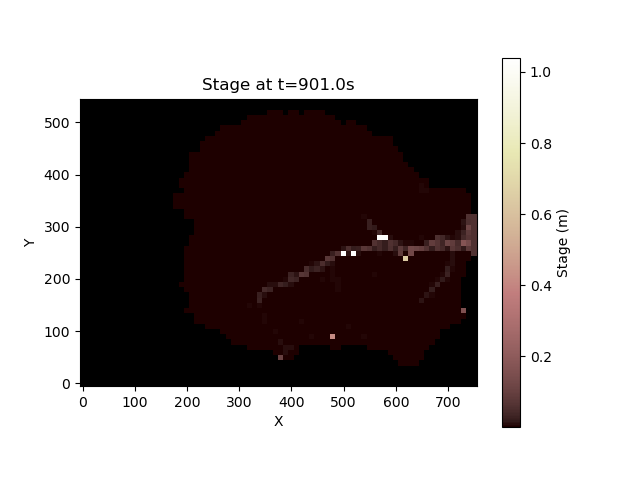

<IPython.core.display.Javascript object>


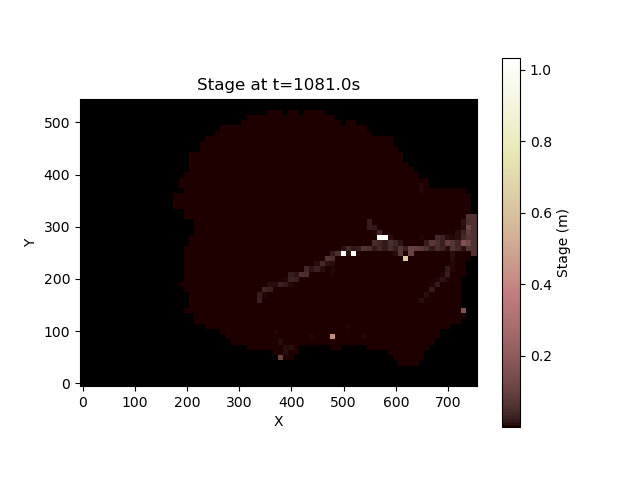

<IPython.core.display.Javascript object>


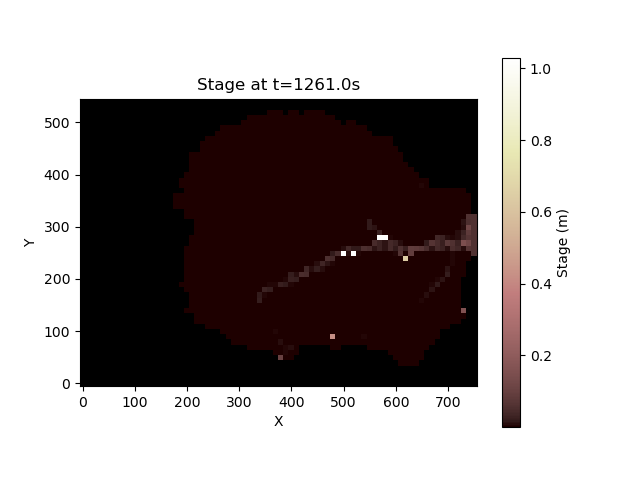

<IPython.core.display.Javascript object>


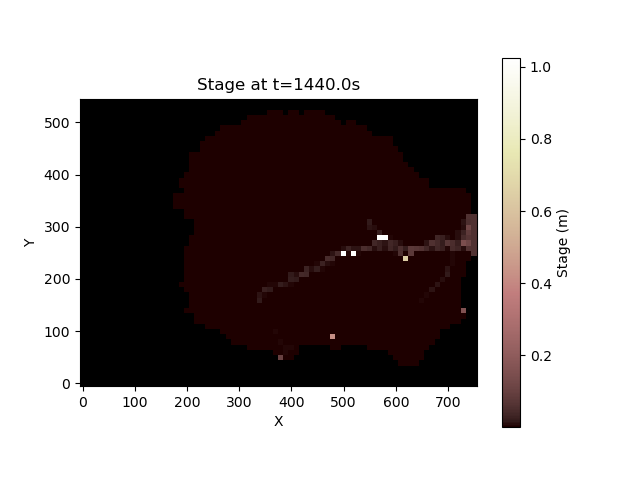

<IPython.core.display.Javascript object>


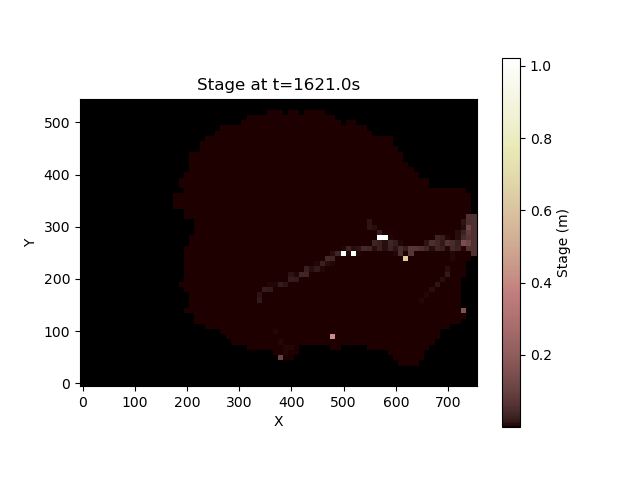

<IPython.core.display.Javascript object>


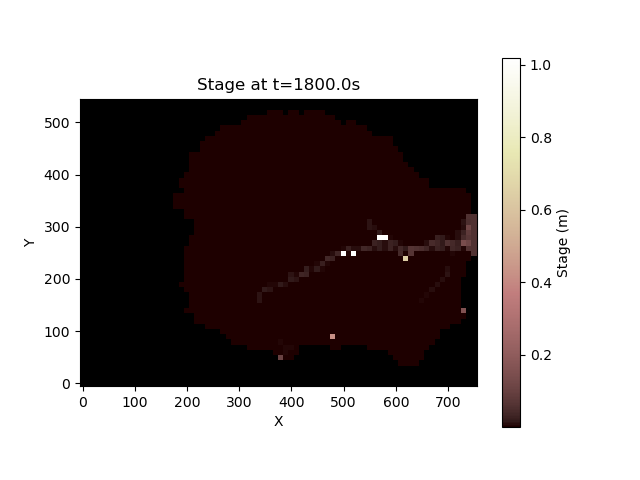

In [4]:
for filename in os.listdir('./rainfall'):  # for each file in the folder
    if filename.endswith(".asc"):  # ...that ends with .asc...
        # remove any rainfall field that already exists on the grid:
        try:
            _ = mg.at_node.pop('rainfall__flux')
        except KeyError:
            pass
        _, q_rain = read_esri_ascii(
            './rainfall/'+filename, grid=mg, name='rainfall__flux')
    else:
        continue
    mg.add_zeros("surface_water__depth", at="node")   
    mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
    mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * storm_t
    of = OverlandFlow(mg, steep_slopes=True)


    # storm_t here is the duration of the rainfall, from the rainfall component
    # We're going to assume the rainfall arrives effectively instantaneously, but
    # adding discharge during the run is completely viable

    node_of_max_q = 2126  # established by examining the output of a previous run
    outlet_depth = []
    outlet_times = []
    post_storm_elapsed_time = 0.
    last_storm_loop_tracker = 0.
    while post_storm_elapsed_time < 0.5 * 3600.:  # plot 30 mins-worth of runoff
        dt = of.calc_time_step()
        of.run_one_step(dt=dt)
        post_storm_elapsed_time += dt
        storm_loop_tracker = post_storm_elapsed_time % 180.  # show every 3 min
        # NB: Do NOT allow this plotting if there are multiple files in the folder
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)')
            plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(post_storm_elapsed_time)

Now, plot the time series at the outlet (defined as the node that experiences peak stage):

<IPython.core.display.Javascript object>


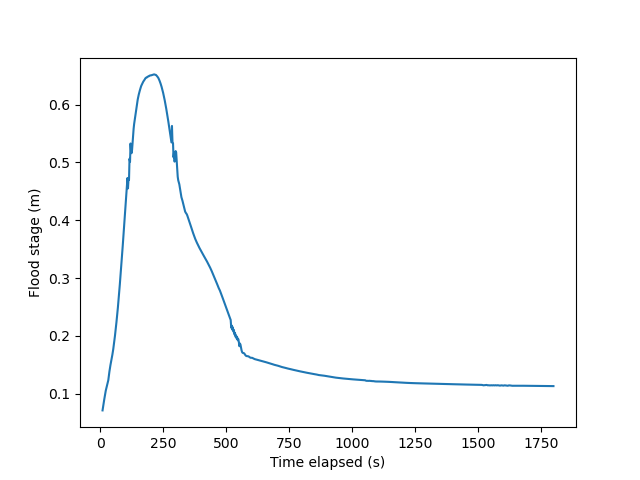

Text(0, 0.5, 'Flood stage (m)')

In [5]:
plt.figure()
plt.plot(outlet_times, outlet_depth, '-')
plt.xlabel('Time elapsed (s)')
plt.ylabel('Flood stage (m)')

We can relax the assumption that all this discharge is delivered instantaneously at the start of the run with some tweaking of the driver:

<IPython.core.display.Javascript object>


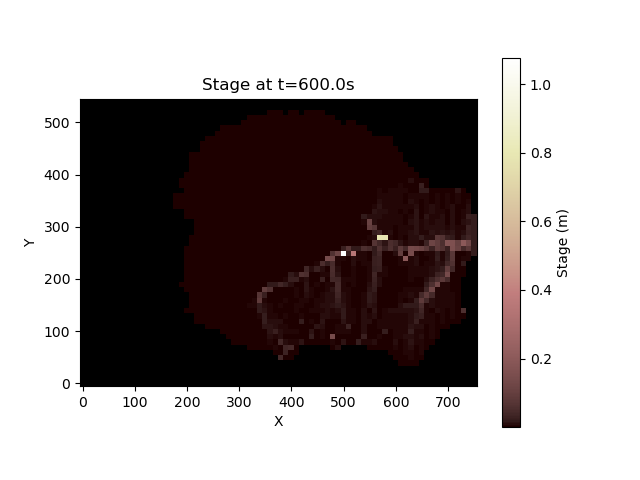

<IPython.core.display.Javascript object>


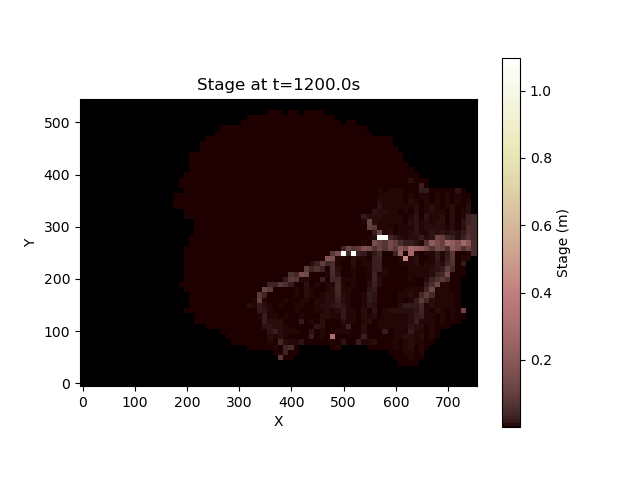

<IPython.core.display.Javascript object>


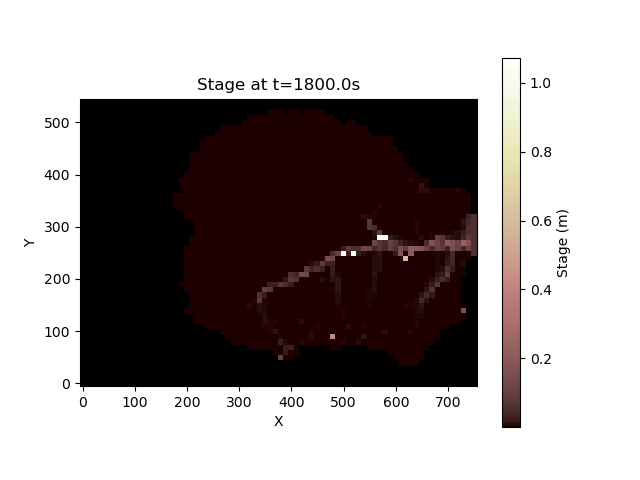

<IPython.core.display.Javascript object>


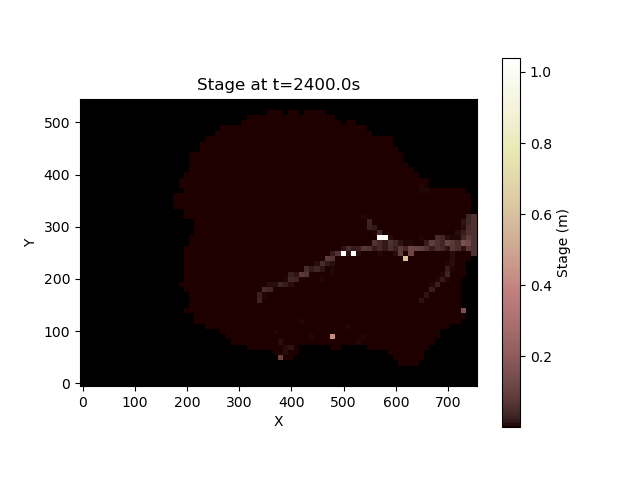

<IPython.core.display.Javascript object>


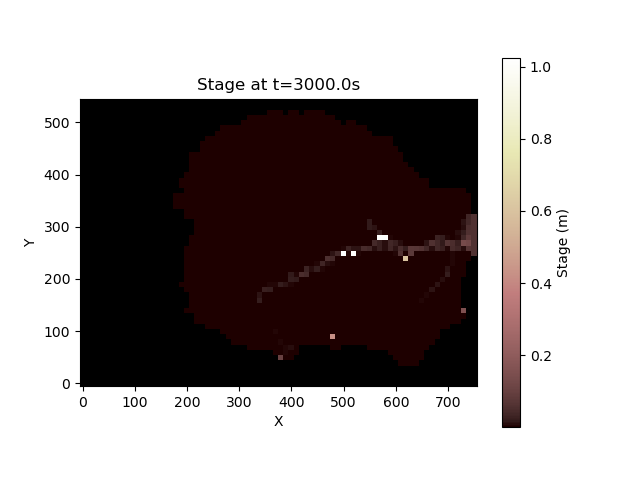

<IPython.core.display.Javascript object>


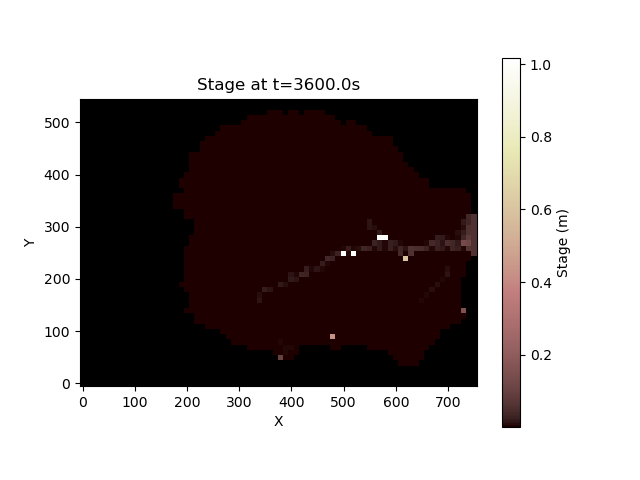

In [6]:
for filename in os.listdir('./rainfall'):  # for each file in the folder
    if filename.endswith(".asc"):  # ...that ends with .asc...
        # remove any rainfall field that already exists on the grid:
        try:
            _ = mg.at_node.pop('rainfall__flux')
        except KeyError:
            pass
        _, q_rain = read_esri_ascii(
            './rainfall/'+filename, grid=mg, name='rainfall__flux')
    else:
        continue
      
    mg.at_node['surface_water__depth'].fill(1.e-12)

    of = OverlandFlow(mg, steep_slopes=True)
    node_of_max_q = 2126
    total_mins_to_plot = 60.  # plot 60 mins-worth of runoff
    plot_interval_mins = 10.  # show every 10 min
    min_tstep_val = 1.  # necessary to get the model going cleanly
    outlet_depth = []
    outlet_times = []
    storm_elapsed_time = 0.
    total_elapsed_time = 0.
    last_storm_loop_tracker = 0.
    while total_elapsed_time < total_mins_to_plot * 60.:
        dt = of.calc_time_step()
        remaining_total_time = total_mins_to_plot * 60. - total_elapsed_time
        if storm_elapsed_time < storm_t * 3600.:
            remaining_storm_time = storm_t * 3600. - storm_elapsed_time
            dt = min((dt, remaining_total_time, remaining_storm_time, min_tstep_val))
        else:
            dt = min((dt, remaining_total_time, min_tstep_val))
        of.run_one_step(dt=dt)
        total_elapsed_time += dt
        storm_elapsed_time += dt
        storm_loop_tracker = total_elapsed_time % (plot_interval_mins * 60.)
        # NB: Do NOT allow this plotting if there are multiple files in the folder
        if storm_loop_tracker < last_storm_loop_tracker:
            plt.figure()
            imshow_grid_at_node(
                mg,
                'surface_water__depth',
                var_name='Stage (m)')
            plt.title('Stage at t=' + str(total_elapsed_time//1) + 's')
            plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(total_elapsed_time)
        if storm_elapsed_time < storm_t * 3600.:
            mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * dt / 3600.

<IPython.core.display.Javascript object>


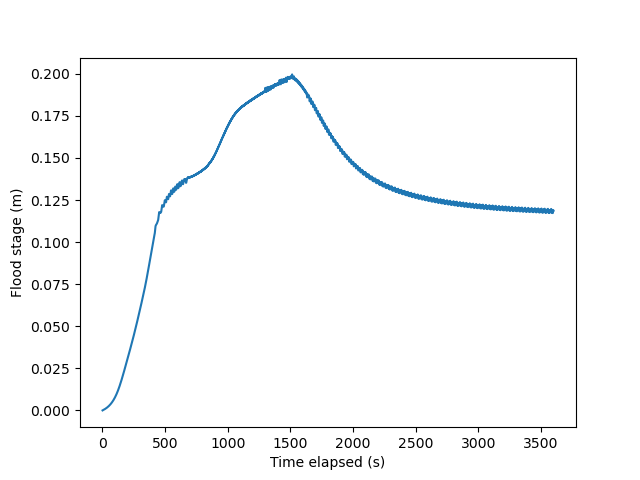

Text(0, 0.5, 'Flood stage (m)')

In [7]:
plt.figure()
plt.plot(outlet_times, outlet_depth, '-')
plt.xlabel('Time elapsed (s)')
plt.ylabel('Flood stage (m)')

As expected, a more realistic spread of the rainfall across the storm gives a longer and more subdued flood pulse.

(An aside: the levelling off of the tail at h~0.125m is likely due to the permanent filling of a depression in the topography - the same thing is probably causing the deep pixels in the flow maps - or are these numerical instabilities? Resolving this is left as an exercise for the reader...)